In [36]:
# Import Libary
import pandas as pd
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import numpy as np
import matplotlib.pyplot as plt

# read data
reviews = pd.read_csv("Hotel_Reviews.csv")

# append the positive and negative text reviews
reviews["review"] = reviews["reviews.title"] + "." + reviews["reviews.text"]

reviews["name"] = reviews["name"]

# create the label and make information easy to understanding
reviews["is_good_review"] = reviews["reviews.rating"].apply(lambda x: 1 if x > 3 else 0)

# If it bad is 0
# If it goof is 1

reviews = reviews[["review", "is_good_review", "name"]]
reviews.head()

,review,is_good_review,name
0,Best Western Plus Hotel.This hotel was nice an...,0,Best Western Plus South Coast Inn
1,Clean rooms at solid rates in the heart of Car...,1,Best Western Carmel's Town House Lodge
2,"Business.Parking was horrible, somebody ran in...",0,Best Western Carmel's Town House Lodge
3,Very good.Not cheap but excellent location. Pr...,1,Best Western Carmel's Town House Lodge
4,Low chance to come back here.If you get the ro...,0,Best Western Carmel's Town House Lodge


In [37]:
reviews.head(10)

,review,is_good_review,name
0,Best Western Plus Hotel.This hotel was nice an...,0,Best Western Plus South Coast Inn
1,Clean rooms at solid rates in the heart of Car...,1,Best Western Carmel's Town House Lodge
2,"Business.Parking was horrible, somebody ran in...",0,Best Western Carmel's Town House Lodge
3,Very good.Not cheap but excellent location. Pr...,1,Best Western Carmel's Town House Lodge
4,Low chance to come back here.If you get the ro...,0,Best Western Carmel's Town House Lodge
5,"Loved staying here.This is such a fun, lovely ...",1,21c Museum Hotel Lexington
6,Does not live up to its reputation.We recently...,0,21c Museum Hotel Lexington
7,worst customer service ever.I reserved a room ...,0,Springs Motel LLC
8,Location Location Location.MoreMore,1,Microtel Inn Suites By Wyndham Lexington
9,"The worst place i've booked.Hello, I have trav...",0,American Inn


In [38]:
# return the wordnet object value corresponding to the POS tag
def get_wordnet_pos(pos_tag):
    
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    
    elif pos_tag.startswith('V'):
        return wordnet.VERBฆ
    
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN
    

In [39]:
def clean_text(text):
    
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    
    # pos tag text
    pos_tags = pos_tag(text)
    
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    
    # join all
    text = " ".join(text)
    return(text)

# clean text data
#4768 
for i in range(len(reviews["review"])): reviews["review_clean"] = clean_text(reviews["review"][i])

In [40]:
#add sentiment anaylsis columns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews["sentiments"] = reviews["review"].apply(lambda x: sid.polarity_scores(x))
reviews = pd.concat([reviews.drop(['sentiments'], axis=1), reviews['sentiments'].apply(pd.Series)], axis=1)

In [41]:
# add number of characters column
reviews["nb_chars"] = reviews["review"].apply(lambda x: len(x))

# add number of words column
reviews["nb_words"] = reviews["review"].apply(lambda x: len(x.split(" ")))

In [42]:
#create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec = reviews["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec.columns = ["doc2vec_vector_" + str(x) for x in doc2vec.columns]
reviews = pd.concat([reviews, doc2vec], axis=1)

In [43]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews.index
reviews = pd.concat([reviews, tfidf_df], axis=1)

In [44]:
reviews["is_good_review"].value_counts(normalize = True)

1    0.7689
0    0.2311
Name: is_good_review, dtype: float64

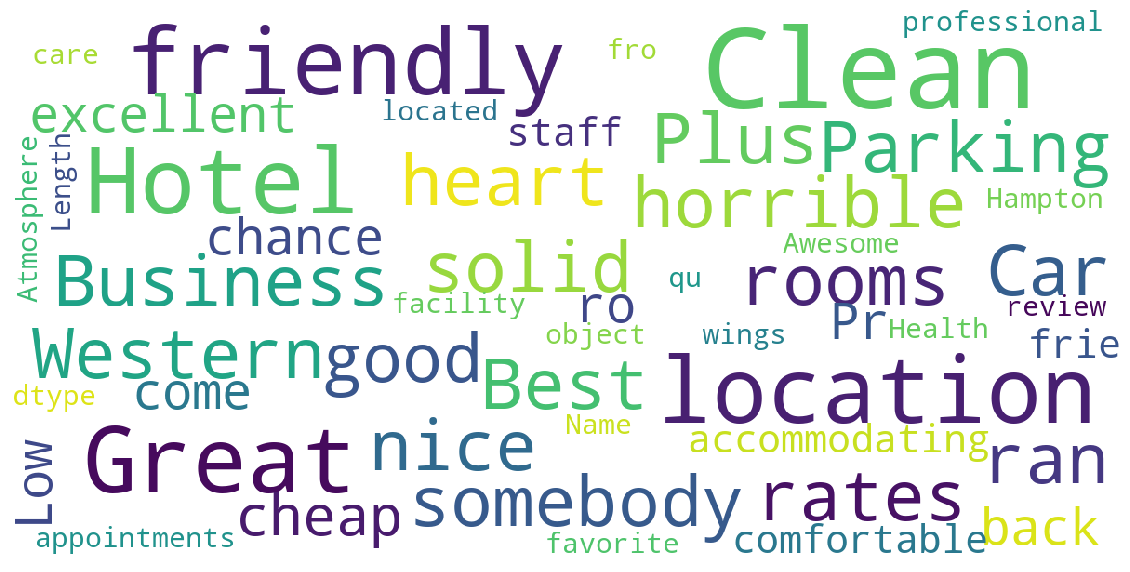

In [45]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews["review"])

In [46]:
# highest positive sentiment reviews (with more than 5 words)
reviews[reviews["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
9734,Great Hotel.The staff was so nice and helpful....,0.645
1975,"Clean, comfortable, and convenient!.The staff ...",0.641
5185,"Very clean, awesome pool, awesome breakfast.Wo...",0.628
9642,Clean Comfy.Great Hotel. Clean and comfortable...,0.601
7254,Perfect!.This hotel is perfectly located on bu...,0.594
8823,"Awesome NOLA experience.Wonderful staff, frien...",0.586
5199,"Great Experience!.awesome place, we were gladl...",0.583
9562,Great value.walking distance to seaworld or fr...,0.570
7308,Great Best Western.Enjoyed my stay there! Alwa...,0.564
587,"Lovely hotel, great location, nice friendly st...",0.563


In [47]:
# lowest negative sentiment reviews (with more than 5 words)
reviews[reviews["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
3636,This is the WORST hotel and the WORST staff..T...,0.438
6977,Horrible hotel dont waste money.The pictures w...,0.384
2334,"There is no fridge, no microwave, no hanger. T...",0.362
4132,"Horrible, bedbags.Infected of fleas and thumbt...",0.353
4984,good location but room let the whole visit dow...,0.337
282,worst stay...left early.The freezing pool. The...,0.324
9,"The worst place i've booked.Hello, I have trav...",0.317
6591,Do not stay here..Very upset with my stay at t...,0.316
8718,"Gateway to Hell.Employees rude, not helpful. D...",0.313
4481,"Meeting Place.Ice machine broken, telephone br...",0.309


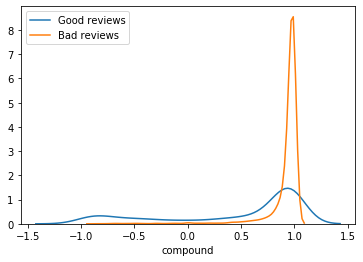

In [48]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = reviews[reviews['is_good_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

In [49]:
# data set category
cat_good = {
    "staff" : ["friendly", "nice", "good","helpful", "great", "polite", "professional", "excellent", "lovely", "courteous", 
               "courteous", "gentle", "gracious", "modest", "bland", "serviceable", "pleasant", "efficient", "engaging", 
               "wonderful", "attentive"],
    "room" : ["clean", "perfectly", "comfortable", "great", "comfort", "beautiful", "quiet", "well", "perfect", "extraordinary",
            "elegant", "privacy","private","safe", "safety", "big" ,"large", "spacious", "best", "convenient"],
    "location" : ["amazing", "great", "nice", "wonderful", "perfect", "perfectly", "best", "convenient"],
    "price" : ["cheap", "inexpensive", "good", "worth", "worthy"],
    "parking" : ["free", "near", "nice", "big"]
    }

# add colunm about category in 'reviews'
reviews["staff"] = 0
reviews["room"] = 0
reviews["location"] = 0
reviews["price"] = 0
reviews["parking"] = 0

# check category in 'reviews'
for i in range(len(reviews['review'])):
    
    lst = reviews["review"][i].lower().split(".")
    
    for text in lst:
        
    # check category about staff in reviews
        if "staff" in text:
            for cate in cat_good["staff"]:
                if cate in text:
                    reviews["staff"][i] += 1
    
    # check category about room in reviews
        if "room" in text:
            for cate in cat_good["room"]:
                if cate in text:
                    reviews["room"][i] += 1
                    
    # check category about location in reviews
        if "location" in text:
            for cate in cat_good["location"]:
                if cate in text:
                    reviews["location"][i] += 1
                    
    # check category about price in reviews
        if "price" in text:
            for cate in cat_good["price"]:
                if cate in text:
                    reviews["price"][i] += 1
    
    # check category about parking in reviews
        if "parking" in text:
            for cate in cat_good["parking"]:
                if cate in text:
                    reviews["parking"][i] += 1

reviews.head(15)

C:\Users\pongp\Miniconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\pongp\Miniconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\pongp\Miniconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\pongp\Miniconda3\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A val

,review,is_good_review,name,review_clean,neg,neu,pos,compound,nb_chars,nb_words,...,word_staff,word_standard,word_stay,word_ut,word_visit,staff,room,location,price,parking
0,Best Western Plus Hotel.This hotel was nice an...,0,Best Western Plus South Coast Inn,health care appointments.clean facility freewa...,0.000,0.777,0.223,0.9042,238,42,...,0.196116,0.196116,0.196116,0.196116,0.196116,0,0,0,0,0
1,Clean rooms at solid rates in the heart of Car...,1,Best Western Carmel's Town House Lodge,health care appointments.clean facility freewa...,0.068,0.782,0.150,0.6673,375,70,...,0.196116,0.196116,0.196116,0.196116,0.196116,0,4,0,0,0
2,"Business.Parking was horrible, somebody ran in...",0,Best Western Carmel's Town House Lodge,health care appointments.clean facility freewa...,0.063,0.880,0.057,-0.0772,297,54,...,0.196116,0.196116,0.196116,0.196116,0.196116,0,0,0,0,0
3,Very good.Not cheap but excellent location. Pr...,1,Best Western Carmel's Town House Lodge,health care appointments.clean facility freewa...,0.039,0.620,0.340,0.9731,320,53,...,0.196116,0.196116,0.196116,0.196116,0.196116,0,1,0,0,0
4,Low chance to come back here.If you get the ro...,0,Best Western Carmel's Town House Lodge,health care appointments.clean facility freewa...,0.158,0.815,0.028,-0.8141,360,66,...,0.196116,0.196116,0.196116,0.196116,0.196116,0,0,0,0,0
5,"Loved staying here.This is such a fun, lovely ...",1,21c Museum Hotel Lexington,health care appointments.clean facility freewa...,0.049,0.726,0.225,0.8793,360,63,...,0.196116,0.196116,0.196116,0.196116,0.196116,0,0,0,0,0
6,Does not live up to its reputation.We recently...,0,21c Museum Hotel Lexington,health care appointments.clean facility freewa...,0.000,0.897,0.103,0.7184,378,67,...,0.196116,0.196116,0.196116,0.196116,0.196116,0,0,0,0,0
7,worst customer service ever.I reserved a room ...,0,Springs Motel LLC,health care appointments.clean facility freewa...,0.102,0.867,0.031,-0.5018,274,48,...,0.196116,0.196116,0.196116,0.196116,0.196116,0,1,0,0,0
8,Location Location Location.MoreMore,1,Microtel Inn Suites By Wyndham Lexington,health care appointments.clean facility freewa...,0.000,1.000,0.000,0.0000,35,3,...,0.196116,0.196116,0.196116,0.196116,0.196116,0,0,0,0,0
9,"The worst place i've booked.Hello, I have trav...",0,American Inn,health care appointments.clean facility freewa...,0.317,0.683,0.000,-0.9791,329,65,...,0.196116,0.196116,0.196116,0.196116,0.196116,0,0,0,0,0


In [50]:
# new dictionary have hotel's name (key) / category (values)
hotel_reviews = {}
all_hotel = []
count = 0

for i in range(len(reviews['review'])):
    
    # add name hotel
    if reviews["name"][i] not in all_hotel:
        hotel_reviews[count] = {"name" : reviews["name"][i], "staff" : 0, "room" : 0, "location" : 0, "price" : 0,\
                                "parking" : 0, "good_comment" : 0, "score" : 0}
        all_hotel.append(reviews["name"][i])
        count += 1
        
    # add values category hotel
    else:
        ind = all_hotel.index(reviews["name"][i]) # find index for find hotel

        hotel_reviews[ind]["staff"] += reviews["staff"][i]
        hotel_reviews[ind]["room"] += reviews["room"][i]
        hotel_reviews[ind]["location"] += reviews["location"][i]
        hotel_reviews[ind]["price"] += reviews["price"][i]
        hotel_reviews[ind]["parking"] += reviews["parking"][i]
        hotel_reviews[ind]["good_comment"] += reviews["pos"][i] - reviews["neg"][i]
        hotel_reviews[ind]["score"] += reviews["staff"][i] + reviews["parking"][i]\
                                    + reviews["room"][i] + reviews["location"][i] + reviews["price"][i]\
                                    + (reviews["pos"][i] - reviews["neg"][i])
        
# sorted hotel reviews by score (high to low)
hotel_reviews = dict(sorted(hotel_reviews.items(), key=lambda kv: kv[1]['score'], reverse=True))

# sorted hotel reviews by comment (high to low)
comment_reviews = dict(sorted(hotel_reviews.items(), key=lambda kv: kv[1]['good_comment'], reverse=True))

# sorted hotel reviews by staff (high to low)
staff_reviews = dict(sorted(hotel_reviews.items(), key=lambda kv: kv[1]['staff'], reverse=True))

# sorted hotel reviews by room (high to low)
room_reviews = dict(sorted(hotel_reviews.items(), key=lambda kv: kv[1]['room'], reverse=True))

# sorted hotel reviews by location (high to low)
location_reviews = dict(sorted(hotel_reviews.items(), key=lambda kv: kv[1]['location'], reverse=True))

# sorted hotel reviews by price (high to low)
price_reviews = dict(sorted(hotel_reviews.items(), key=lambda kv: kv[1]['price'], reverse=True))

# sorted hotel reviews by parking (high to low)
parking_reviews = dict(sorted(hotel_reviews.items(), key=lambda kv: kv[1]['parking'], reverse=True))

In [51]:
# Dictionary to Dataframe
hotel_reviews = pd.DataFrame.from_dict(hotel_reviews, orient='index')

#        staff room location price parking score
# name0    1    2      3       4     5       6
# name1    1    2      3       4     5       6
# name2    1    2      3       4     5       6
# name3    1    2      3       4     5       6

# comment
comment_reviews = pd.DataFrame.from_dict(comment_reviews, orient='index')

# staff
staff_reviews = pd.DataFrame.from_dict(staff_reviews, orient='index')

# room
room_reviews = pd.DataFrame.from_dict(room_reviews, orient='index')

# location
location_reviews = pd.DataFrame.from_dict(location_reviews, orient='index')

# price
price_reviews = pd.DataFrame.from_dict(price_reviews, orient='index')

# parking
parking_reviews = pd.DataFrame.from_dict(parking_reviews, orient='index')

In [52]:
# Top 10 Ranking Score to create bar graph (Sum All Score)

# List for name of Hotels
lst = [i for i in hotel_reviews['name']]
names = []
for i in range(10):
    names.append(lst[i])
    
# List for score of Comments
lst = [i for i in comment_reviews['good_comment']]
comment = []
for i in range(10):
    comment.append(lst[i])

# List for score of Staff
lst = [i for i in hotel_reviews['staff']]
staff = []
for i in range(10):
    staff.append(lst[i])

# List for score of Room
lst = [i for i in hotel_reviews['room']]
room = []
for i in range(10):
    room.append(lst[i])
    
# List for score of Location
lst = [i for i in hotel_reviews['location']]
location = []
for i in range(10):
    location.append(lst[i])
    
# List for score of Price
lst = [i for i in hotel_reviews['price']]
price = []
for i in range(10):
    price.append(lst[i])
    
# List for score of Parking
lst = [i for i in hotel_reviews['parking']]
parking = []
for i in range(10):
    parking.append(lst[i])


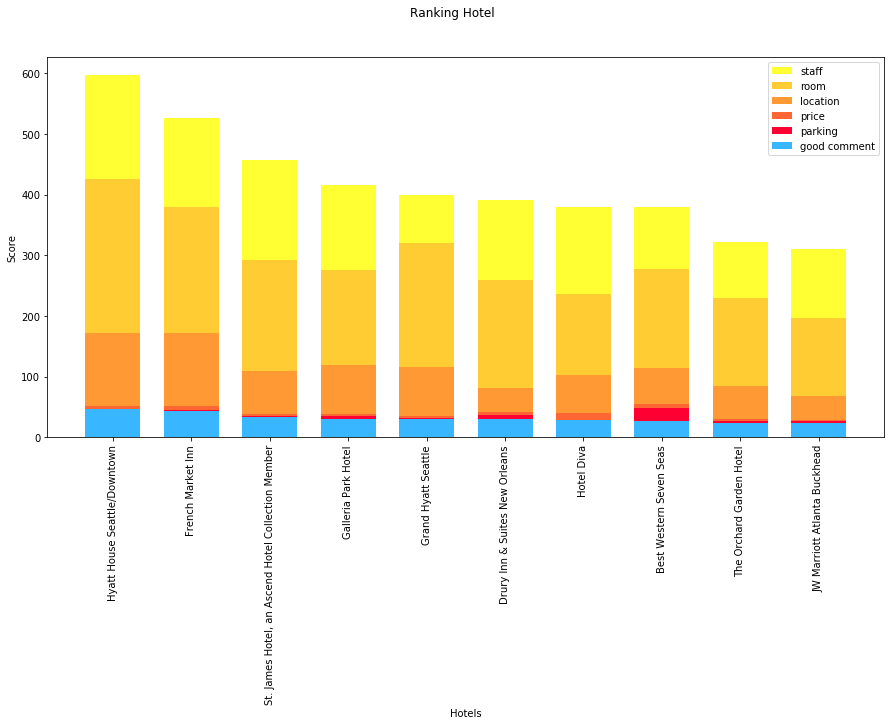

In [53]:
# Create Stacked Bar Graph =w=
comment = np.array(comment)
staff = np.array(staff)
room = np.array(room)
location = np.array(location)
price = np.array(price)
parking = np.array(parking)

score = [str(i) for i in hotel_reviews['score']]

# Fig size
plt.figure(figsize=(15, 7))

# Stacked Graph
plt.bar(names, staff, width=0.7, label='staff', color='#FFFF33', bottom=room+location+price+parking+comment) # Staff
plt.bar(names, room, width=0.7, label='room', color='#FFCC33', bottom=location+price+parking+comment)        # Room
plt.bar(names, location, width=0.7, label='location', color='#FF9933', bottom=price+parking+comment)         # Location
plt.bar(names, price, width=0.7, label='price', color='#FF6633', bottom=parking+comment)                     # Price
plt.bar(names, parking, width=0.7, label='parking', color='#FF0033', bottom=comment)                         # Parking
plt.bar(names, comment, width=0.7, label='good comment', color='#38b6ff')                                    # Good Reviews

# Plot Graph
plt.suptitle("Ranking Hotel")
plt.xticks(rotation=90)
plt.xlabel("Hotels")
plt.ylabel("Score")
plt.legend(loc="upper right")

# Show Graph
plt.show()

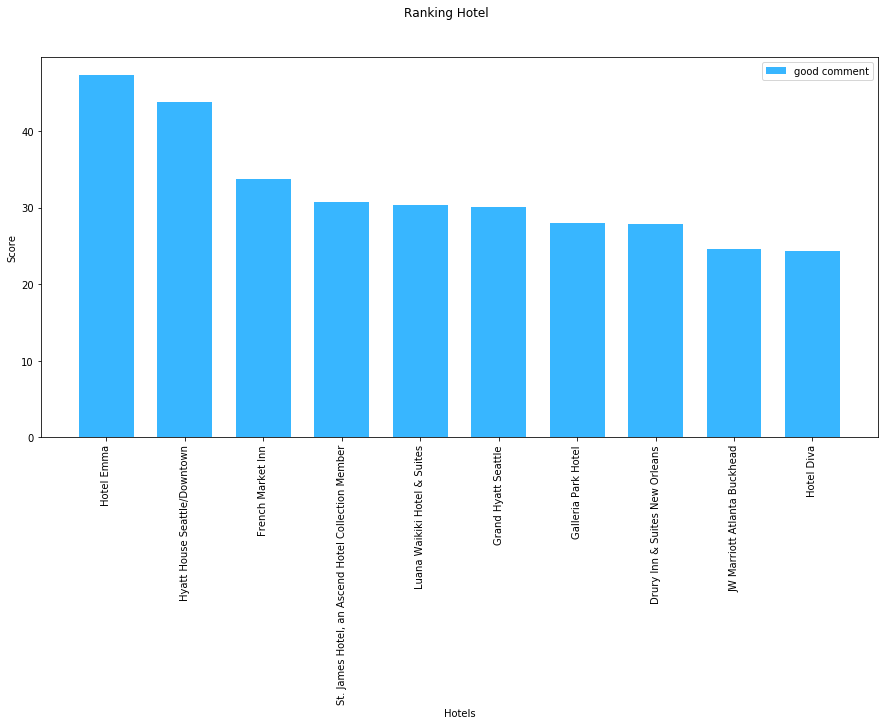

In [54]:
# Top 10 Ranking Score to create bar graph (***Comment*** All Score)

# List for score of Name
lst = [i for i in comment_reviews['name']]
names = []
for i in range(10):
    names.append(lst[i])
    
# List for score of Comments
lst = [i for i in comment_reviews['good_comment']]
comment = []
for i in range(10):
    comment.append(lst[i])

# Create Stacked Bar Graph =w=
comment = np.array(comment)

# Fig size
plt.figure(figsize=(15, 7))

# Stacked Graph
plt.bar(names, comment, width=0.7, label='good comment', color='#38b6ff') # Good Reviews

# Plot Graph
plt.suptitle("Ranking Hotel")
plt.xticks(rotation=90)
plt.xlabel("Hotels")
plt.ylabel("Score")
plt.legend(loc="upper right")

# Show Graph
plt.show()

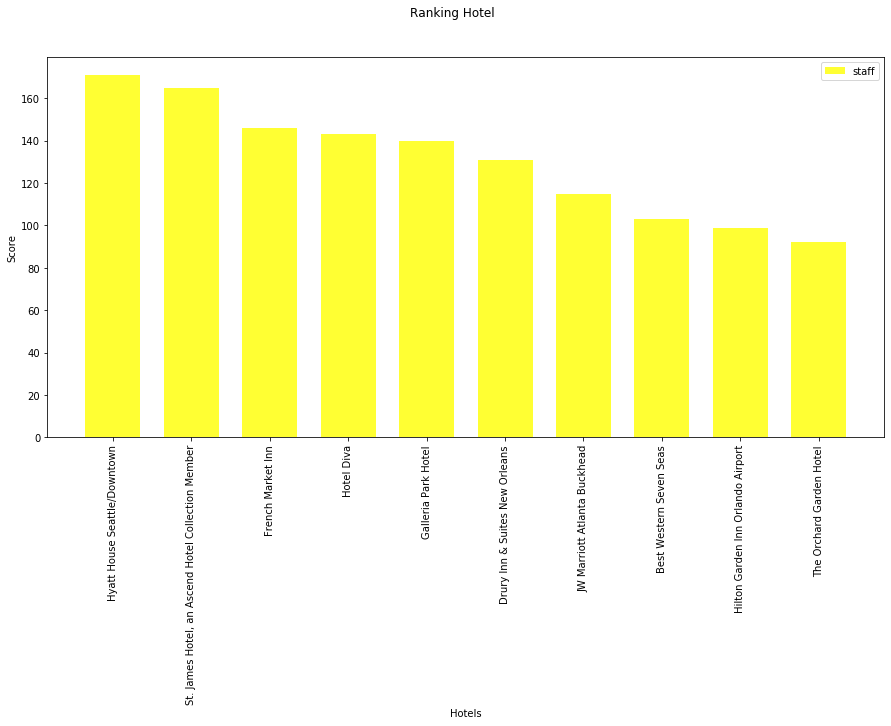

In [55]:
# เผื่อเอาไปใช้ ถ้าไม่ใช้ก็ลบได้ (ข้างล่างนี้)
# Top 10 Ranking Score to create bar graph (***Staff*** All Score)

# List for name of Hotels
lst = [i for i in staff_reviews['name']]
names = []
for i in range(10):
    names.append(lst[i])

# List for score of Staff
lst = [i for i in staff_reviews['staff']]
staff = []
for i in range(10):
    staff.append(lst[i])

# Create Stacked Bar Graph =w=
staff = np.array(staff)

# Fig size
plt.figure(figsize=(15, 7))

# Stacked Graph
plt.bar(names, staff, width=0.7, label='staff', color='#FFFF33') # Staff

# Plot Graph
plt.suptitle("Ranking Hotel")
plt.xticks(rotation=90)
plt.xlabel("Hotels")
plt.ylabel("Score")
plt.legend(loc="upper right")

# Show Graph
plt.show()

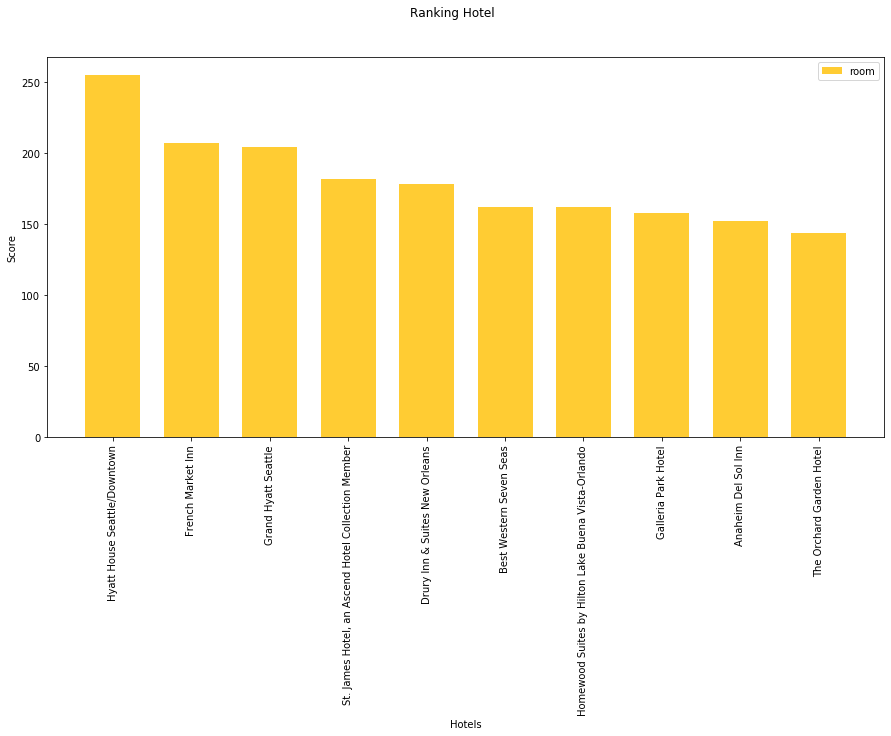

In [56]:
# เผื่อเอาไปใช้ ถ้าไม่ใช้ก็ลบได้ (ข้างล่างนี้)
# Top 10 Ranking Score to create bar graph (***Room*** All Score)

# List for name of Hotels
lst = [i for i in room_reviews['name']]
names = []
for i in range(10):
    names.append(lst[i])

# List for score of Room
lst = [i for i in room_reviews['room']]
room = []
for i in range(10):
    room.append(lst[i])

# Create Stacked Bar Graph =w=
room = np.array(room)

# Fig size
plt.figure(figsize=(15, 7))

# Stacked Graph
plt.bar(names, room, width=0.7, label='room', color='#FFCC33') # Room

# Plot Graph
plt.suptitle("Ranking Hotel")
plt.xticks(rotation=90)
plt.xlabel("Hotels")
plt.ylabel("Score")
plt.legend(loc="upper right")

# Show Graph
plt.show()

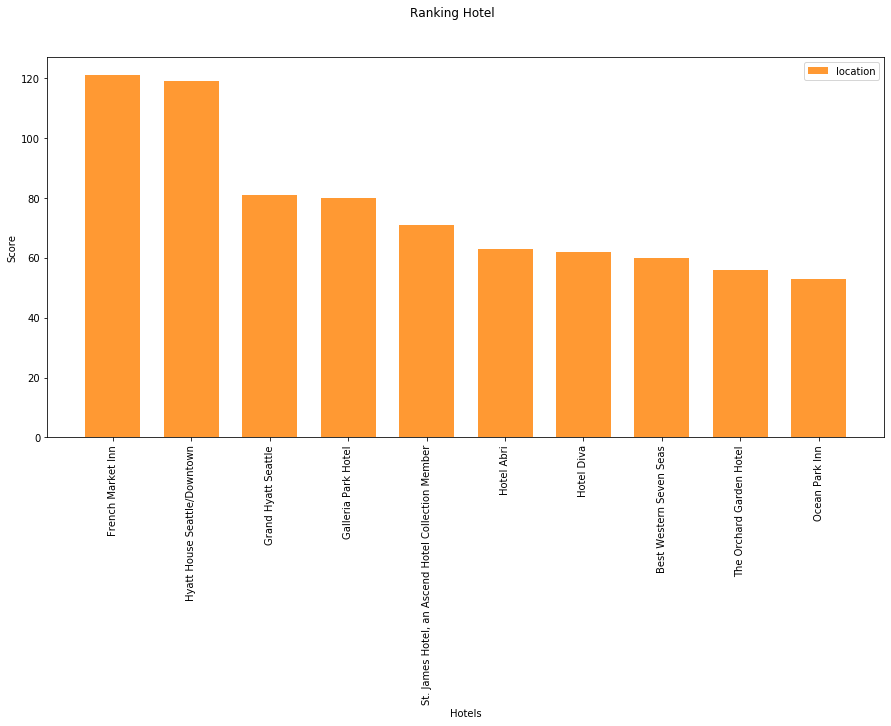

In [57]:
# เผื่อเอาไปใช้ ถ้าไม่ใช้ก็ลบได้ (ข้างล่างนี้)
# Top 10 Ranking Score to create bar graph (***Location*** All Score)

# List for name of Hotels
lst = [i for i in location_reviews['name']]
names = []
for i in range(10):
    names.append(lst[i])
    
# List for score of Location
lst = [i for i in location_reviews['location']]
location = []
for i in range(10):
    location.append(lst[i])

# Create Stacked Bar Graph =w=
location = np.array(location)

# Fig size
plt.figure(figsize=(15, 7))

# Stacked Graph
plt.bar(names, location, width=0.7, label='location', color='#FF9933') # Location

# Plot Graph
plt.suptitle("Ranking Hotel")
plt.xticks(rotation=90)
plt.xlabel("Hotels")
plt.ylabel("Score")
plt.legend(loc="upper right")

# Show Graph
plt.show()

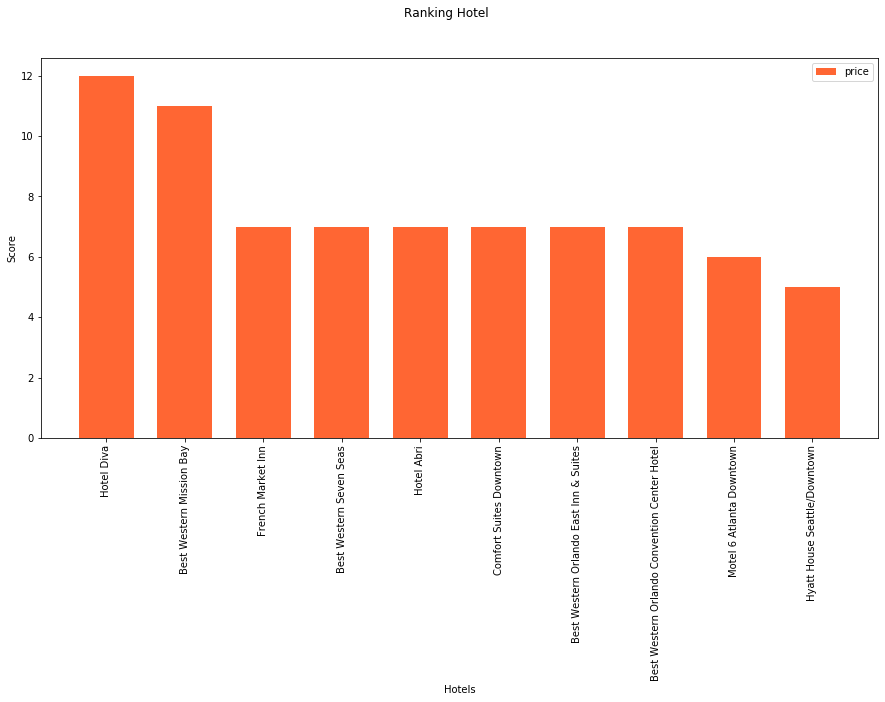

In [58]:
# เผื่อเอาไปใช้ ถ้าไม่ใช้ก็ลบได้ (ข้างล่างนี้)
# Top 10 Ranking Score to create bar graph (***Price*** All Score)

# List for name of Hotels
lst = [i for i in price_reviews['name']]
names = []
for i in range(10):
    names.append(lst[i])
    
# List for score of Price
lst = [i for i in price_reviews['price']]
price = []
for i in range(10):
    price.append(lst[i])

# Create Stacked Bar Graph =w=
price = np.array(price)

# Fig size
plt.figure(figsize=(15, 7))

# Stacked Graph
plt.bar(names, price, width=0.7, label='price', color='#FF6633') # Price

# Plot Graph
plt.suptitle("Ranking Hotel")
plt.xticks(rotation=90)
plt.xlabel("Hotels")
plt.ylabel("Score")
plt.legend(loc="upper right")

# Show Graph
plt.show()

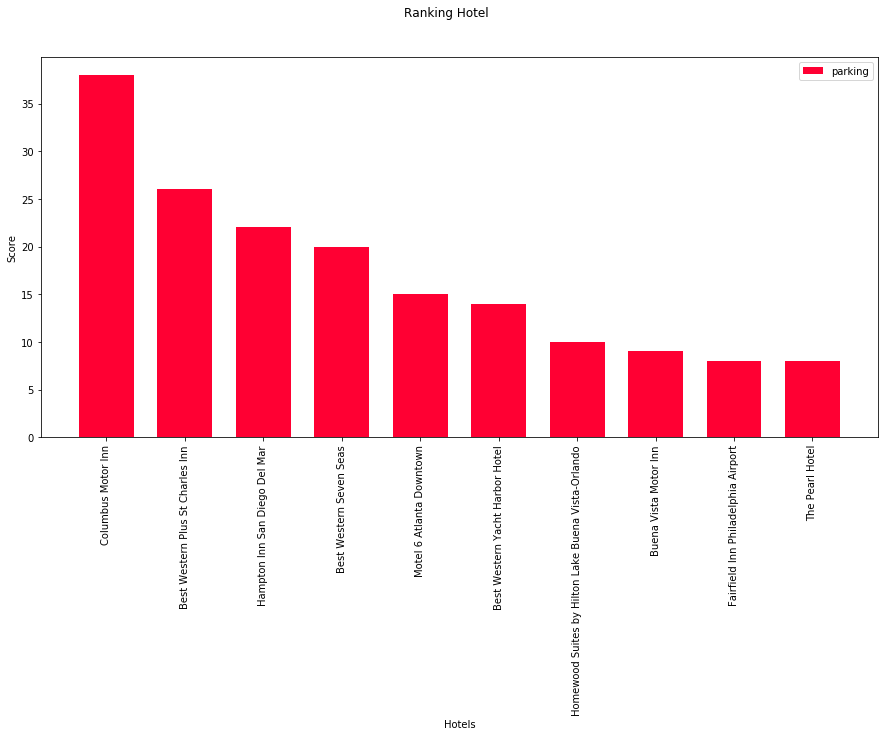

In [59]:
# เผื่อเอาไปใช้ ถ้าไม่ใช้ก็ลบได้ (ข้างล่างนี้)
# Top 10 Ranking Score to create bar graph (***Parking*** All Score)

# List for name of Hotels
lst = [i for i in parking_reviews['name']]
names = []
for i in range(10):
    names.append(lst[i])
    
# List for score of Parking
lst = [i for i in parking_reviews['parking']]
parking = []
for i in range(10):
    parking.append(lst[i])

# Create Stacked Bar Graph =w=
parking = np.array(parking)

# Fig size
plt.figure(figsize=(15, 7))

# Stacked Graph
plt.bar(names, parking, width=0.7, label='parking', color='#FF0033') # Parking

# Plot Graph
plt.suptitle("Ranking Hotel")
plt.xticks(rotation=90)
plt.xlabel("Hotels")
plt.ylabel("Score")
plt.legend(loc="upper right")

# Show Graph
plt.show()